# ECON 326 Final Project
#### Members: Lucy Zhu, Cynthia Cui, Kaylie Nguyen

## Importing Packages

In [1]:
library(tidyr)
library(tidyverse) 
library(haven)
library(dplyr)
library(stargazer)
library(lmtest)
library(sandwich)
library(car)
library(vtable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ dplyr   1.1.1
✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 0.5.2
✔ purrr   1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: kableExtra


Attaching package: ‘kableExtra’


The following object is masked fr

## Data Loading

In [2]:
amazon_data <- read.csv("data/amazon_beauty_data.csv")
head(amazon_data)

,X,main_cat,price,asin,rank,overall
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0,All Beauty,,6546546450,"2,938,573 in Beauty & Personal Care (",4
2,1,All Beauty,,6546546450,"2,938,573 in Beauty & Personal Care (",1
3,2,All Beauty,$44.99,7178680776,"872,854 in Beauty & Personal Care (",3
4,3,All Beauty,$28.76,7250468162,"956,696 in Beauty & Personal Care (",5
5,4,All Beauty,,7367905066,"1,870,258 in Beauty & Personal Care (",5
6,5,All Beauty,$12.15,7414204790,"67,701 in Beauty & Personal Care (",5


## Data Wrangling

In this part, we will extract the data so that `price` and `rank`, which are currently of type `chr`, will only include the numeric values of interest. In addition, since each observation is the ratings on a buyer for a certain products, a products can appear on multiple rows. We will group by the product code (`asin`) and find the average rating for each of the product, which is our variable of interest.

In [3]:
amazon_data <- amazon_data %>%
        mutate(main_cat = as.factor(main_cat))%>%
        mutate(price =substr(price, 2, nchar(price)))%>%
        mutate(price = as.numeric(price))%>%
        mutate(rank= parse_number(rank))%>%
        group_by(asin)%>%
        summarize(product_avg_ratings = mean(overall), price = price, main_cat = main_cat, rank=rank)
head(amazon_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `price = as.numeric(price)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `rank = parse_number(rank)`.
Caused by warning:
! 4957 parsing failures.
 row col expected actual
4148  -- a number     []
4149  -- a number     []
4350  -- a number     []
4351  -- a number     []
4352  -- a number     []
.... ... ........ ......
See problems(...) for more details.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'asin'. You can override using the
`.groups` argument.


asin,product_avg_ratings,price,main_cat,rank
<chr>,<dbl>,<dbl>,<fct>,<dbl>
6546546450,2.5,NA,All Beauty,2938573
6546546450,2.5,NA,All Beauty,2938573
7178680776,3.0,44.99,All Beauty,872854
7250468162,5.0,28.76,All Beauty,956696
7367905066,5.0,NA,All Beauty,1870258
7414204790,4.4,12.15,All Beauty,67701


## Statistics Summary

In this step, we obtain an overall summary of the data in order to explore it and to prepare for cleaning the data.

In [4]:
summary(amazon_data)

     asin           product_avg_ratings     price        
 Length:982762      Min.   :1.000       Min.   :   0.01  
 Class :character   1st Qu.:4.000       1st Qu.:  12.76  
 Mode  :character   Median :4.263       Median :  23.00  
                    Mean   :4.180       Mean   :  34.07  
                    3rd Qu.:4.481       3rd Qu.:  40.18  
                    Max.   :5.000       Max.   : 999.99  
                                        NA's   :304810   
          main_cat           rank        
 All Beauty   :382532   Min.   :     35  
 Luxury Beauty:600230   1st Qu.:  14577  
                        Median :  71046  
                        Mean   : 263249  
                        3rd Qu.: 352479  
                        Max.   :9549407  
                        NA's   :4957     

## Data Cleaning

We will drop the missing values below and remove duplicate rows for the products.

In [5]:
amazon_data <- amazon_data %>%
        drop_na()%>%
        distinct(asin, .keep_all=TRUE)
head(amazon_data)

asin,product_avg_ratings,price,main_cat,rank
<chr>,<dbl>,<dbl>,<fct>,<dbl>
7178680776,3.00000,44.99,All Beauty,872854
7250468162,5.00000,28.76,All Beauty,956696
7414204790,4.40000,12.15,All Beauty,67701
8921463194,1.00000,24.99,All Beauty,1676787
9752980953,1.00000,21.95,All Beauty,2325042
9790787006,4.22807,13.85,All Beauty,298893


Moreover, since the main category is a categorical variable with 2 values "All Beauty" and "Luxury Beauty", we will encode it as a dummy variable where 0 represents "All Beauty" and 1 represents "Luxury Beauty."

In [6]:
amazon_data['main_cat'] <-  as.numeric(amazon_data$main_cat)-1
head(amazon_data)

asin,product_avg_ratings,price,main_cat,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7178680776,3.00000,44.99,0,872854
7250468162,5.00000,28.76,0,956696
7414204790,4.40000,12.15,0,67701
8921463194,1.00000,24.99,0,1676787
9752980953,1.00000,21.95,0,2325042
9790787006,4.22807,13.85,0,298893


Finally, we will add a new columns in which we transform our variables to be used in the model. We will add the column for the natural log of price, a column for percentage rank and a column for the interaction term between log(price) and the main category. Specifically, for the rank, we need to transform it because the values of the rank are on a much larger scale than our dependent variable. Therefore, if we do not transform it, the coefficients on the ranking will be extremely small due to the nature of the scale, which is difficult to interpret.

In [7]:
amazon_data <- amazon_data %>%
                mutate(logprice=log(price), pct_rank = 1-rank/max(amazon_data$rank))%>%
                mutate(interaction = logprice*main_cat) #this will be used for the VIF test, not the regression
head(amazon_data)

asin,product_avg_ratings,price,main_cat,rank,logprice,pct_rank,interaction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7178680776,3.00000,44.99,0,872854,3.806440,0.9085960,0
7250468162,5.00000,28.76,0,956696,3.358986,0.8998162,0
7414204790,4.40000,12.15,0,67701,2.497329,0.9929104,0
8921463194,1.00000,24.99,0,1676787,3.218476,0.8244093,0
9752980953,1.00000,21.95,0,2325042,3.088767,0.7565250,0
9790787006,4.22807,13.85,0,298893,2.628285,0.9687004,0


## Cleaned Data Summary

In [8]:
st(amazon_data,
         summ=c('min(x)',
                'mean(x)',
                'max(x)',
                'sd(x)'),
  out="return")

Variable,Min,Mean,Max,Sd
<chr>,<chr>,<chr>,<chr>,<chr>
product_avg_ratings,1,4.1,5,0.92
price,0.01,34,1000,47
main_cat,0,0.38,1,0.49
rank,35,617067,9549407,633782
logprice,-4.6,3.1,6.9,0.95
pct_rank,0,0.94,1,0.066
interaction,0,1.3,6.4,1.8


## Model

In [9]:
regA<-lm(data=amazon_data,product_avg_ratings~logprice)
regB<-lm(data=amazon_data,product_avg_ratings~logprice+main_cat)
regC<-lm(data=amazon_data,product_avg_ratings~logprice+main_cat+logprice:main_cat)
regD<-lm(data=amazon_data,product_avg_ratings~logprice+main_cat+pct_rank)
regE<-lm(data=amazon_data,product_avg_ratings~logprice+main_cat+logprice:main_cat+pct_rank)
stargazer(regA, regB, regC,regD,regE, title="Comparison of Regression Results",
          align = TRUE, type="text")


Comparison of Regression Results
                                                                            Dependent variable:                                                         
                    ------------------------------------------------------------------------------------------------------------------------------------
                                                                            product_avg_ratings                                                         
                               (1)                        (2)                       (3)                       (4)                        (5)            
--------------------------------------------------------------------------------------------------------------------------------------------------------
logprice                     0.094***                  0.101***                  0.138***                   0.113***                   0.151***         
                             (0.007)            

## Specification Check

### 1. VIF test on different regressions

In [10]:
vif(regB, type = "terms")

logprice main_cat 
1.137845 1.137845

In [11]:
vif(regC, type = "terms")

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



logprice          main_cat logprice:main_cat 
         1.577688         17.191687         19.343475

In [12]:
vif(regD, type = "terms")

logprice main_cat pct_rank 
1.147737 1.467743 1.300024

In [13]:
vif(regE, type = "terms")

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



logprice          main_cat          pct_rank logprice:main_cat 
         1.588859         17.479817          1.300139         19.345180

In [14]:
#from the above analysis, we can see that "logprice:main_cat" and "main_cat" are highly collinear, this can be further verified as follows:
vif_int_on_cat <- lm(interaction ~ main_cat, data = amazon_data)

r_2_cat <- summary(vif_int_on_cat)$r.squared

1/(1-r_2_cat)

[1] 13.95071

New names:
• `` -> `...9`
New names:
• `` -> `...9`


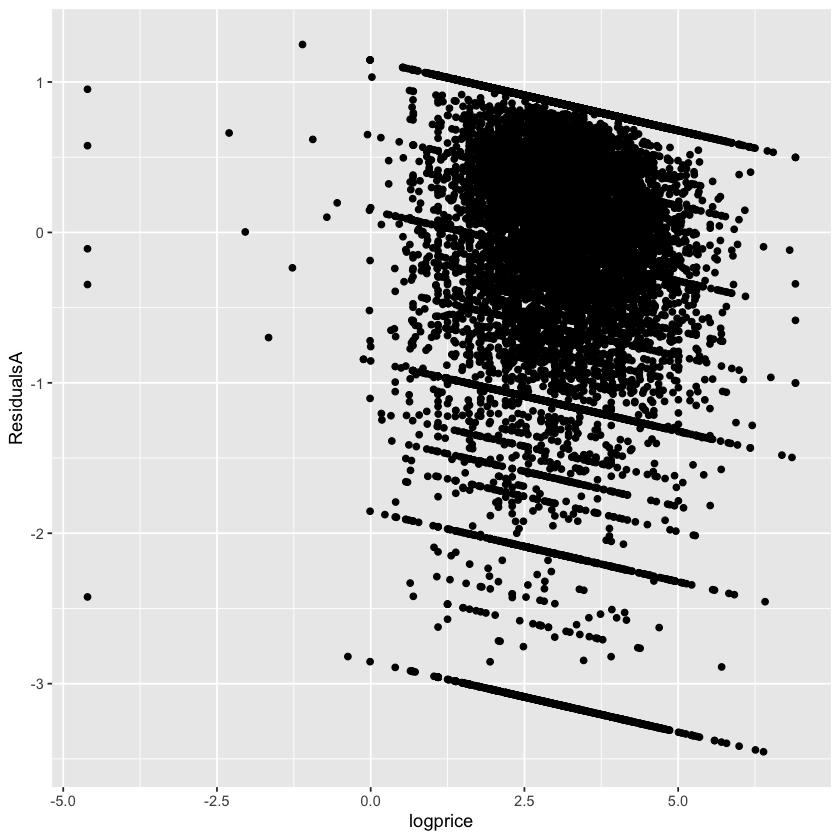

New names:
• `` -> `...9`


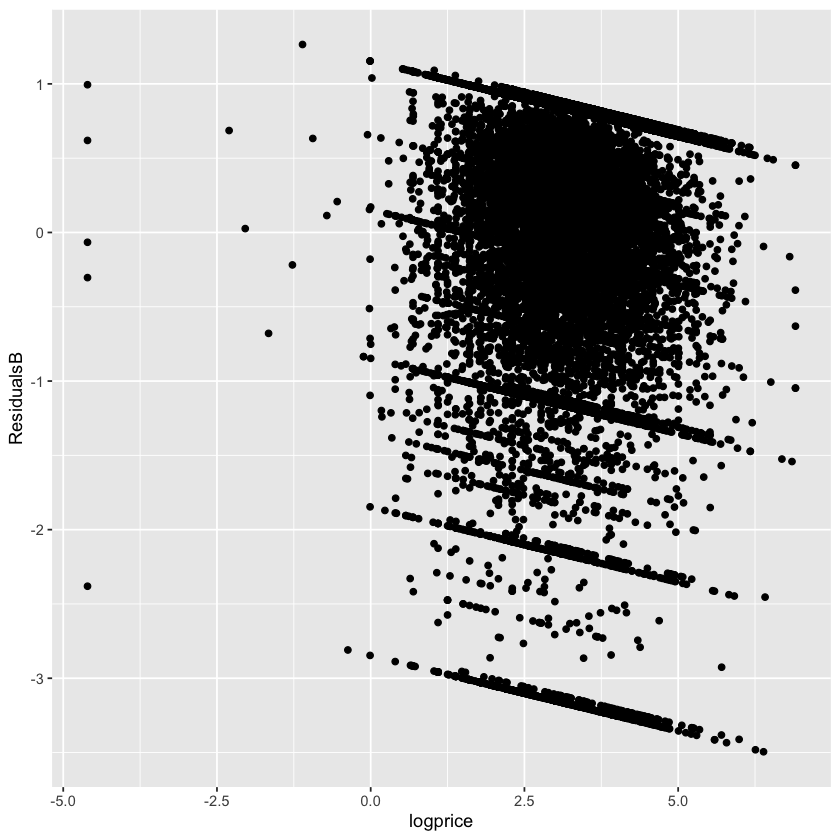

New names:
• `` -> `...9`


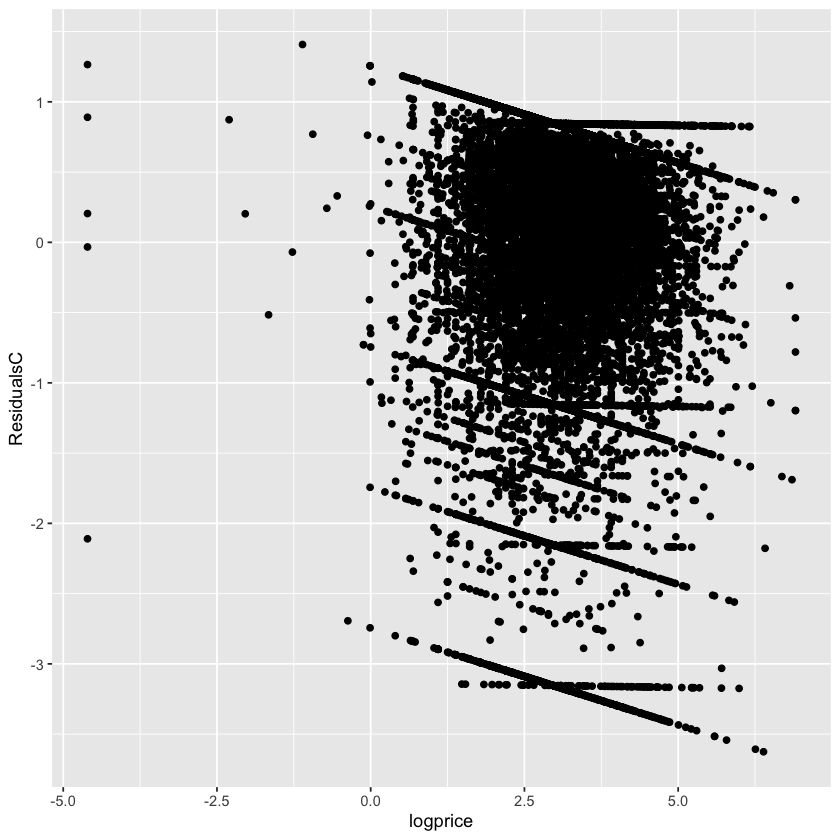

New names:
• `` -> `...9`


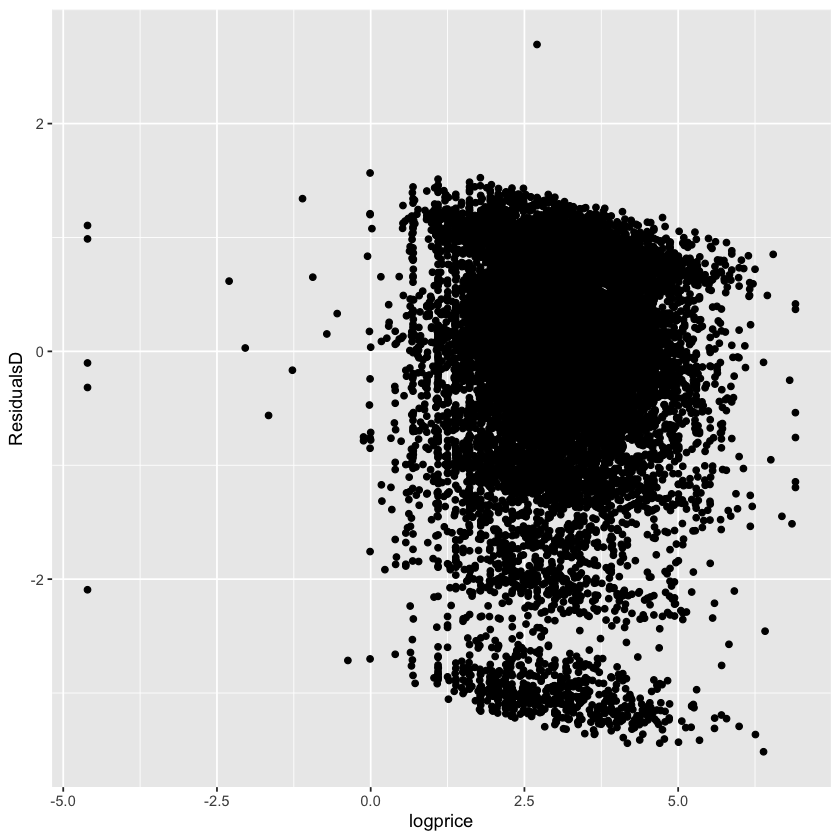

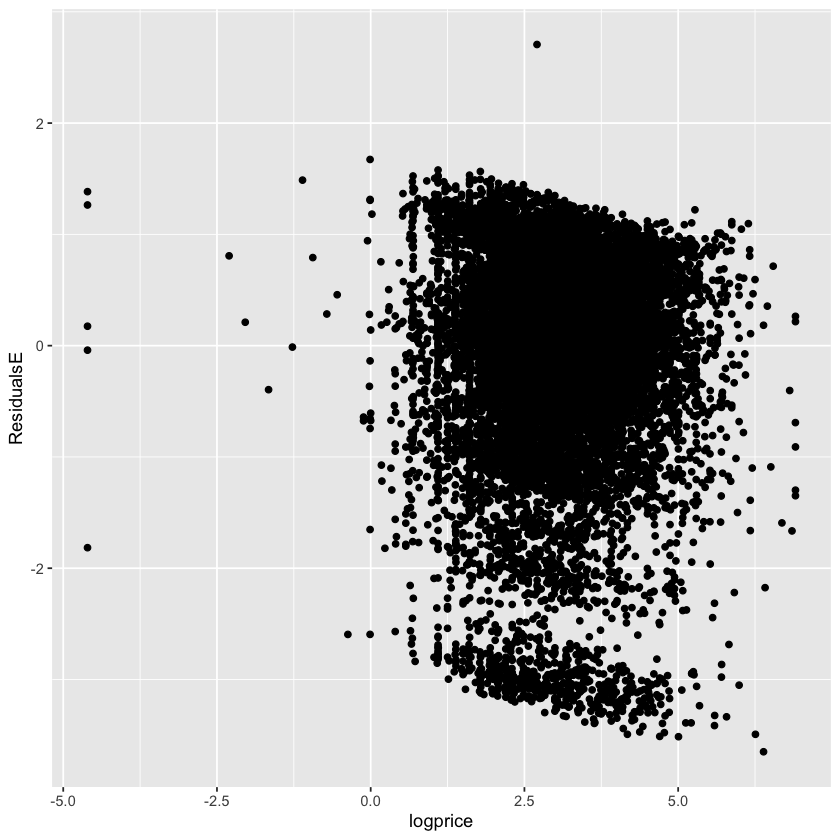

In [15]:
ggplot(data =cbind(amazon_data, regA$residuals), aes(x = as.numeric(amazon_data$logprice), y = as.numeric(regA$residuals))) + geom_point() + labs(x = "logprice", y = "ResidualsA")
ggplot(data =cbind(amazon_data, regB$residuals), aes(x = as.numeric(amazon_data$logprice), y = as.numeric(regB$residuals))) + geom_point() + labs(x = "logprice", y = "ResidualsB")
ggplot(data =cbind(amazon_data, regC$residuals), aes(x = as.numeric(amazon_data$logprice), y = as.numeric(regC$residuals))) + geom_point() + labs(x = "logprice", y = "ResidualsC")
ggplot(data =cbind(amazon_data, regD$residuals), aes(x = as.numeric(amazon_data$logprice), y = as.numeric(regD$residuals))) + geom_point() + labs(x = "logprice", y = "ResidualsD")
ggplot(data =cbind(amazon_data, regE$residuals), aes(x = as.numeric(amazon_data$logprice), y = as.numeric(regE$residuals))) + geom_point() + labs(x = "logprice", y = "ResidualsE")

### 2. White's Test
Although the means are roughly zero (which is good), but the residuals are definitely not homoskedastic. Here we'll employ the White's test to show the heteroskedasticity

In [16]:
y_hatA <- predict(regA)
res_sqA <- regA$residuals^2
white_A <- lm(res_sqA ~ y_hatA + I(y_hatA^2))
summary(white_A)


Call:
lm(formula = res_sqA ~ y_hatA + I(y_hatA^2))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7111 -0.7402 -0.4957 -0.0512 10.8447 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 111.3903    15.4928   7.190 6.74e-13 ***
y_hatA      -52.3915     7.4875  -6.997 2.70e-12 ***
I(y_hatA^2)   6.2023     0.9046   6.856 7.30e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.801 on 17933 degrees of freedom
Multiple R-squared:  0.00537,	Adjusted R-squared:  0.005259 
F-statistic: 48.41 on 2 and 17933 DF,  p-value: < 2.2e-16


In [17]:
y_hatB <- predict(regB)
res_sqB <- regB$residuals^2
white_B <- lm(res_sqB ~ y_hatB + I(y_hatB^2))
summary(white_B)


Call:
lm(formula = res_sqB ~ y_hatB + I(y_hatB^2))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7219 -0.7567 -0.5041 -0.0416 10.7536 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 111.1735    14.1536   7.855 4.23e-15 ***
y_hatB      -52.9635     6.8322  -7.752 9.52e-15 ***
I(y_hatB^2)   6.3528     0.8245   7.705 1.38e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.814 on 17933 degrees of freedom
Multiple R-squared:  0.003579,	Adjusted R-squared:  0.003467 
F-statistic:  32.2 on 2 and 17933 DF,  p-value: 1.096e-14


In [18]:
y_hatC <- predict(regC)
res_sqC <- regC$residuals^2
white_C <- lm(res_sqC ~ y_hatC + I(y_hatC^2))
summary(white_C)


Call:
lm(formula = res_sqC ~ y_hatC + I(y_hatC^2))

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9354 -0.7522 -0.5134 -0.0645 11.3998 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  80.6760     7.9325  10.170   <2e-16 ***
y_hatC      -38.3319     3.8393  -9.984   <2e-16 ***
I(y_hatC^2)   4.5979     0.4648   9.893   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.813 on 17933 degrees of freedom
Multiple R-squared:  0.005888,	Adjusted R-squared:  0.005777 
F-statistic: 53.11 on 2 and 17933 DF,  p-value: < 2.2e-16


In [19]:
y_hatD <- predict(regD)
res_sqD <- regD$residuals^2
white_D <- lm(res_sqD ~ y_hatD + I(y_hatD^2))
summary(white_D)


Call:
lm(formula = res_sqD ~ y_hatD + I(y_hatD^2))

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2268 -0.6361 -0.3580 -0.0227 12.1638 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  51.0351     4.5651  11.179   <2e-16 ***
y_hatD      -21.8419     2.2389  -9.756   <2e-16 ***
I(y_hatD^2)   2.3438     0.2745   8.539   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.645 on 17933 degrees of freedom
Multiple R-squared:  0.06051,	Adjusted R-squared:  0.0604 
F-statistic: 577.5 on 2 and 17933 DF,  p-value: < 2.2e-16


In [20]:
y_hatE <- predict(regE)
res_sqE <- regE$residuals^2
white_E <- lm(res_sqE ~ y_hatE + I(y_hatE^2))
summary(white_E)


Call:
lm(formula = res_sqE ~ y_hatE + I(y_hatE^2))

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0664 -0.6333 -0.3697 -0.0279 13.1279 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  45.6000     3.6532  12.482   <2e-16 ***
y_hatE      -19.4407     1.7923 -10.847   <2e-16 ***
I(y_hatE^2)   2.0807     0.2199   9.462   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.648 on 17933 degrees of freedom
Multiple R-squared:  0.05806,	Adjusted R-squared:  0.05796 
F-statistic: 552.7 on 2 and 17933 DF,  p-value: < 2.2e-16


All five F-statistics are high, meaning the coefficients on y-hat and y-hat^2 are definitely not zero, which is a sign of heteroskedasticity

In [21]:
# Because of heteroskedasticity, we need to use robust standard errors to correct the standard errors in the previous table
seA<-sqrt(diag(vcovHC(regA,type="HC1")))
seB<-sqrt(diag(vcovHC(regB,type="HC1")))
seC<-sqrt(diag(vcovHC(regC,type="HC1")))
seD<-sqrt(diag(vcovHC(regD,type="HC1")))
seE<-sqrt(diag(vcovHC(regE,type="HC1")))
stargazer(regA, regB, regC,regD,regE, title="Robust SE Regression Results",
          align = TRUE, type="text", se=list(seA,seB,seC,seD,seE))


Robust SE Regression Results
                                                                            Dependent variable:                                                         
                    ------------------------------------------------------------------------------------------------------------------------------------
                                                                            product_avg_ratings                                                         
                               (1)                        (2)                       (3)                       (4)                        (5)            
--------------------------------------------------------------------------------------------------------------------------------------------------------
logprice                     0.094***                  0.101***                  0.138***                   0.113***                   0.151***         
                             (0.008)                

## Robustness Analysis
We will divide the products based on their categories to see how the results might change, first we run the regression on All_beauty

In [22]:
reg1<-lm(data=filter(amazon_data,main_cat=="0"),product_avg_ratings~logprice)
reg2<-lm(data=filter(amazon_data,main_cat=="0"),product_avg_ratings~logprice+main_cat+interaction+pct_rank) #equivalent to product_avg_ratings~logprice+pct_rank
stargazer(reg1, reg2, title="Regression Results for All Beauty",
          align = TRUE, type="text")



Regression Results for All Beauty
                                     Dependent variable:                 
                    -----------------------------------------------------
                                     product_avg_ratings                 
                               (1)                        (2)            
-------------------------------------------------------------------------
logprice                     0.138***                   0.149***         
                             (0.010)                    (0.010)          
                                                                         
main_cat                                                                 
                                                                         
                                                                         
interaction                                                              
                                                                         
   

In [23]:
#corrected for heteroskedasticity
se1<-sqrt(diag(vcovHC(reg1,type="HC1")))
se2<-sqrt(diag(vcovHC(reg2,type="HC1")))
stargazer(reg1, reg2, title="Robust SE Regression Results for All Beauty",
          align = TRUE, type="text", se=list(se1,se2))


Robust SE Regression Results for All Beauty
                                     Dependent variable:                 
                    -----------------------------------------------------
                                     product_avg_ratings                 
                               (1)                        (2)            
-------------------------------------------------------------------------
logprice                     0.138***                   0.149***         
                             (0.011)                    (0.011)          
                                                                         
main_cat                                                                 
                                                                         
                                                                         
interaction                                                              
                                                                   

In [24]:
#For Luxury_beauty
reg3<-lm(data=filter(amazon_data,main_cat=="1"),product_avg_ratings~logprice)
reg4<-lm(data=filter(amazon_data,main_cat=="1"),product_avg_ratings~logprice+main_cat+interaction+pct_rank) #equivalent to product_avg_ratings~logprice+pct_rank
stargazer(reg3, reg4, title="Regression Results for Luxury Beauty",
          align = TRUE, type="text")


Regression Results for Luxury Beauty
                                 Dependent variable:              
                    ----------------------------------------------
                                 product_avg_ratings              
                            (1)                     (2)           
------------------------------------------------------------------
logprice                   0.007                 0.029***         
                          (0.011)                 (0.010)         
                                                                  
main_cat                                                          
                                                                  
                                                                  
interaction                                                       
                                                                  
                                                                  
pct_rank                

In [25]:
#corrected for heteroskedasticity
se3<-sqrt(diag(vcovHC(reg3,type="HC1")))
se4<-sqrt(diag(vcovHC(reg4,type="HC1")))
stargazer(reg3, reg4, title="Robust SE Regression Results for Luxury Beauty",
          align = TRUE, type="text", se=list(se3,se4))


Robust SE Regression Results for Luxury Beauty
                                 Dependent variable:              
                    ----------------------------------------------
                                 product_avg_ratings              
                            (1)                     (2)           
------------------------------------------------------------------
logprice                   0.007                  0.029**         
                          (0.012)                 (0.012)         
                                                                  
main_cat                                                          
                                                                  
                                                                  
interaction                                                       
                                                                  
                                                                  
pct_rank      